In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.linear_model import LinearRegression

# 通気層の対流熱伝達率の推定方法の検証
## 分析用データの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('wall_status_data_frame.csv', index_col=0)

# 温度差の列を追加
df["delta_theta_as_e-theta_r"] = df["theta_as_e"] - df["theta_r"]
df["delta_theta_sat-theta_r"] = df["theta_sat"] - df["theta_r"]


# 収束しなかった場合のデータを削除する
df = df.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df = df.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df = df[~np.isnan(df).any(axis=1)]

## 冬期条件、夏期条件の計算結果をそれぞれ抽出

In [3]:
# 冬期条件の計算結果を抽出
df_winter = df.query("theta_e <= 10.0 & theta_r == 20.0")
#df_winter.to_csv("wall_status_winter.csv")
df_winter

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.538192,0.817940,-2.315751,2.842171e-14,2.886580e-15,-1.776357e-15,-2.842171e-14,-2.220446e-16,-24.538192,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.941901,0.831397,-2.401513,0.000000e+00,7.105427e-15,-7.105427e-15,5.684342e-14,-8.881784e-16,-24.941901,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.989114,0.832970,-2.426156,2.842171e-14,0.000000e+00,-3.552714e-15,2.842171e-14,4.440892e-16,-24.989114,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.898810,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.907471,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,24.918480,0.163949,11.581242,-4.547474e-13,-3.979039e-13,-1.136868e-13,0.000000e+00,-1.776357e-15,4.918480,30.0
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,28.197296,0.273243,20.333083,4.547474e-13,0.000000e+00,1.136868e-13,-5.684342e-14,8.881784e-16,8.197296,30.0
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,15.758518,-0.141383,-9.968510,-4.547474e-13,1.527667e-12,8.526513e-14,2.842171e-14,-1.776357e-15,-4.241482,30.0
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,20.797442,0.026581,1.976428,4.547474e-13,-3.410605e-13,-5.684342e-14,0.000000e+00,8.881784e-16,0.797442,30.0


In [4]:
# 夏期条件の計算結果を抽出
df_summer = df.query("theta_e >= 25.0 & theta_r == 27.0")
#df_summer.to_csv("wall_status_summer.csv")
df_summer

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.350496,0.824752,-0.151263,0.000000e+00,-1.261213e-13,-1.456613e-13,0.000000e+00,0.000000e+00,-1.649504,-2.0
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.331103,0.834448,-0.160687,-1.136868e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.668897,-2.0
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.332025,0.833987,-0.162361,0.000000e+00,-1.421085e-14,2.842171e-14,0.000000e+00,0.000000e+00,-1.667975,-2.0
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.011235,0.994383,-0.191872,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,0.000000e+00,-1.988765,-2.0
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.018480,0.990760,-0.193134,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,3.552714e-15,-1.981520,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.476449,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.754820,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.700991,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,49.057263,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


### 通気層の対流熱伝達率（h_cv）、放射熱伝達率（h_rv）の要約統計量を表示

In [5]:
# 冬期条件
df_winter.loc[:,["h_cv","h_rv"]].describe()

,h_cv,h_rv
count,157464.000000,157464.000000
mean,3.980423,2.343079
std,2.275915,1.524278
min,0.016690,0.409954
25%,1.519923,0.527565
50%,4.430121,2.353212
75%,5.845541,3.788173
max,9.267936,6.240892


In [6]:
# 夏期条件
df_summer.loc[:,["h_cv","h_rv"]].describe()

,h_cv,h_rv
count,177147.000000,177147.000000
mean,3.610828,3.064465
std,2.223652,1.974123
min,0.002467,0.594610
25%,1.244865,0.664768
50%,3.769325,3.070385
75%,5.326074,5.109931
max,9.264223,7.795880


## 作図用の関数を定義
### 散布図（線形回帰式あり）を作図する関数を定義

In [7]:
def setPltSingle(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str):
    
    """
    グラフを描画する（2変数の散布図、線形回帰式あり）
    
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, ax = plt.subplots()

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()

    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
    
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = df[y_data_name].to_numpy().reshape(-1, 1)

    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    b = model_lr.intercept_[0] # 切片 (誤差)
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")
        
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x),color="black")

    # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
    ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.1, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
    #ax.text(np.median(x) + np.median(x) * 0.1, np.median(y), 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
    # 決定係数の表示
    ax.text(np.mean(x), np.mean(y) + np.mean(y) * 0.4, 'R2='+ str(round(r2,4)))
    #ax.text(np.median(x) + np.median(x) * 0.1, np.median(y)-1, 'R2='+ str(round(r2,4)))

    # グラフ描画
    plt.show()

### 推定値の確認用グラフ

In [8]:
def setPltComparison(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data:np.array):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, ax = plt.subplots()

    # グラフタイトルを設定
    fig.suptitle('Comparison Result of h_cv')
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
        
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = y_data
                
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")

    # 線形グラフの描画設定    
    ax.plot([-5.0, 15.0], [-5.0, 15.0],color="black")
        
    # 軸の描画範囲設定
    ax.set_xlim(-5.0, 15.0)
    ax.set_ylim(-5.0, 15.0)
    
    # グラフ描画
    plt.show()

## 対流熱伝達率の検証
### 重回帰分析：冬期条件

In [9]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_cv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_winter = ols(formula_1, df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_cv   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 1.462e+05
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:17:31   Log-Likelihood:            -1.6264e+05
No. Observations:              157464   AIC:                         3.253e+05
Df Residuals:                  157452   BIC:                         3.254e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2009      0.008    153.920      0.000       1.186       1.216
theta_e         -0.0190      0.000    -93.445      0.000      -0.019      -0.019
j_surf           0.0003   4.08e-06     65.235      0.000       0.000       0.000
a_surf           0.2659      0.004     65.235      0.000       0.258       0.274
C_1              0.0043   4.22e-05    102.728      0.000       0.004       0.004
C_2              0.1791      0.001    209.159      0.000       0.177       0.181
l_h             -0.0041      0.000     -8.819      0.000      -0.005      -0.003
l_w          -5.417e-11      0.000  -1.28e-07      1.000      -0.001       0.001
l_d             -1.8319      0.017   -109.148      0.000      -1.865      -1.799
angle           -0.0036   4.66e-05    -77.726      0.000      -0.004      -0.004
v_a              5.1578      0.004   1229.240      0.000       5.150       5.166
emissivity_2    -0.4439      0.005    -84.639      0.000      -0.454      -0.434
==============================================================================
Omnibus:                     2678.120   Durbin-Watson:                   0.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3946.954
Skew:                           0.196   Prob(JB):                         0.00
Kurtosis:                       3.669   Cond. No.                     6.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 重回帰分析：夏期条件

In [10]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_cv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_summer = ols(formula_1, df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_cv   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 1.926e+05
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:17:32   Log-Likelihood:            -1.6599e+05
No. Observations:              177147   AIC:                         3.320e+05
Df Residuals:                  177135   BIC:                         3.321e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5865      0.013    -46.107      0.000      -0.611      -0.562
theta_e          0.0327      0.000     90.857      0.000       0.032       0.033
j_surf           0.0008   3.59e-06    233.034      0.000       0.001       0.001
a_surf           0.8376      0.004    233.034      0.000       0.831       0.845
C_1              0.0054   3.61e-05    150.110      0.000       0.005       0.005
C_2              0.1204      0.001    164.194      0.000       0.119       0.122
l_h             -0.0031      0.000     -7.746      0.000      -0.004      -0.002
l_w           3.871e-13      0.000   1.07e-09      1.000      -0.001       0.001
l_d             -1.5712      0.014   -109.282      0.000      -1.599      -1.543
angle           -0.0038   3.99e-05    -94.688      0.000      -0.004      -0.004
v_a              4.9831      0.004   1386.344      0.000       4.976       4.990
emissivity_2    -0.4458      0.004    -99.222      0.000      -0.455      -0.437
==============================================================================
Omnibus:                     1608.544   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1652.679
Skew:                           0.237   Prob(JB):                         0.00
Kurtosis:                       3.004   Cond. No.                     6.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 散布図による検証
### 外気温度（theta_e）× 対流熱伝達率（h_cv）

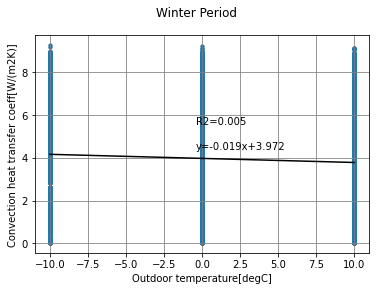

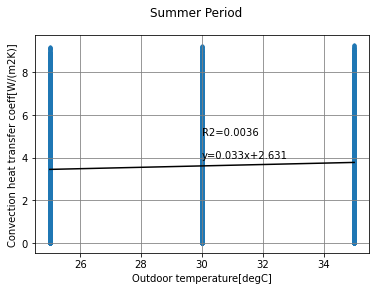

In [11]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_cv"
      )

### 外気側表面に入射する日射量（j_surf）× 対流熱伝達率（h_cv）

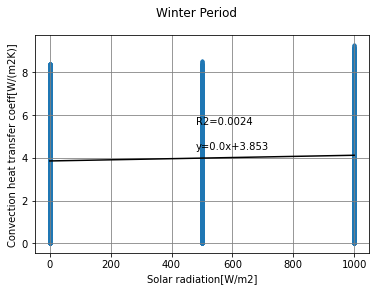

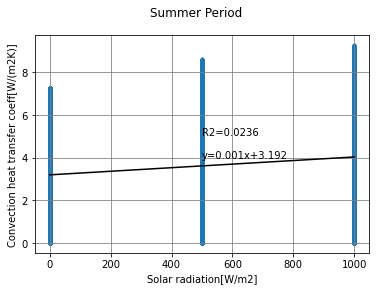

In [12]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_cv"
      )

### 外気側表面日射吸収率（a_surf）× 対流熱伝達率（h_cv）

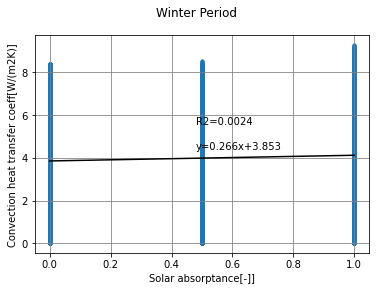

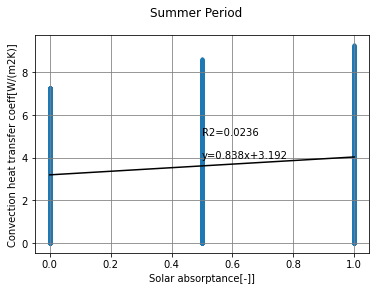

In [13]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_cv"
      )

### 外気側部材の熱コンダクタンス（C_1）× 対流熱伝達率（h_cv）

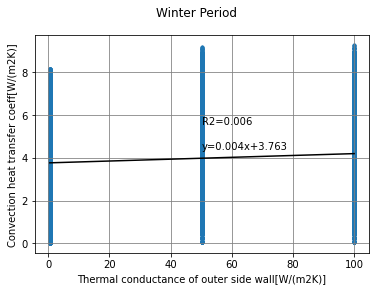

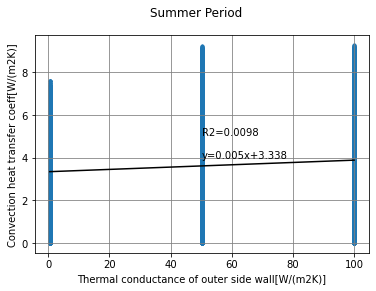

In [14]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_cv"
      )

### 室内側部材の熱コンダクタンス（C_2）× 対流熱伝達率（h_cv）

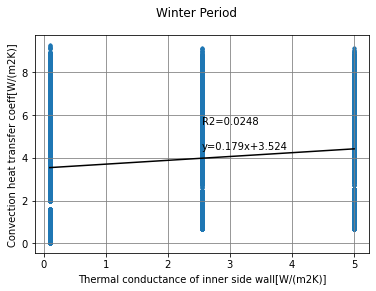

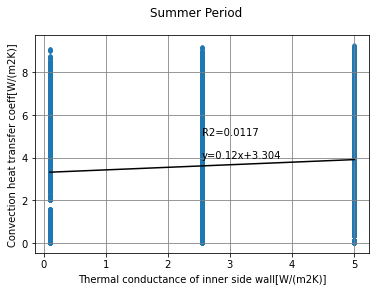

In [15]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_cv"
      )

### 通気層の長さ（l_h）× 対流熱伝達率（h_cv）

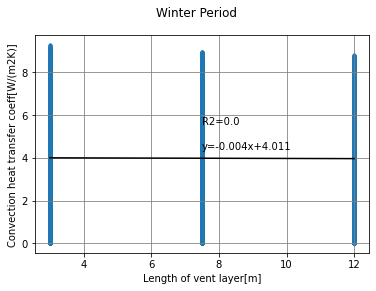

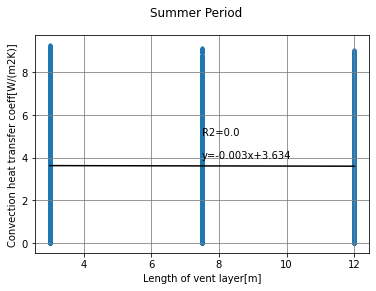

In [16]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Length of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Length of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_cv"
      )

### 通気層の厚さ（l_d）× 対流熱伝達率（h_cv）

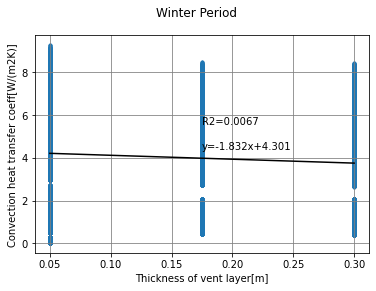

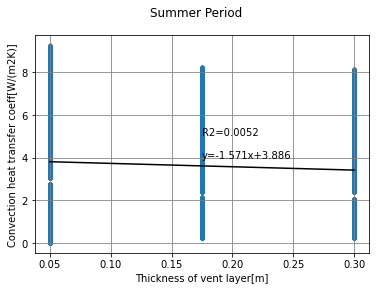

In [17]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_cv"
      )

### 通気層の傾斜角（angle）× 対流熱伝達率（h_cv）

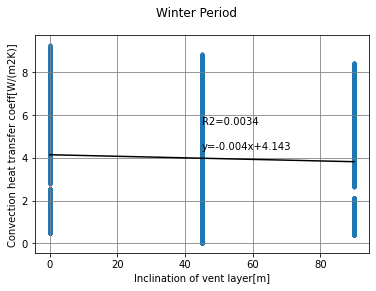

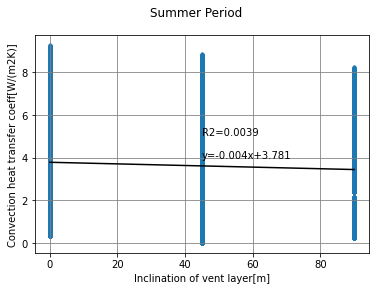

In [18]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_cv"
      )

### 通気層の平均風速（v_a）× 対流熱伝達率（h_cv）

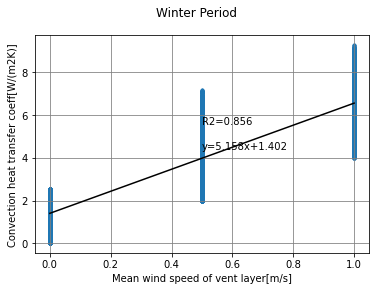

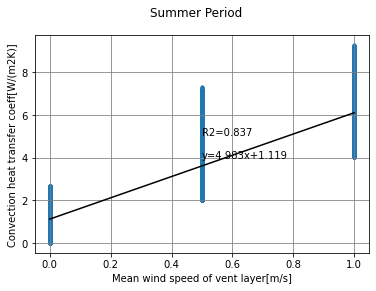

In [19]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_cv"
      )

### 通気層に面する面2の放射率（emissivity_2）× 対流熱伝達率（h_cv）

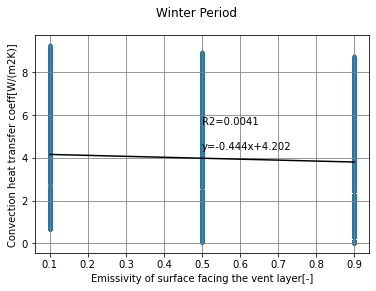

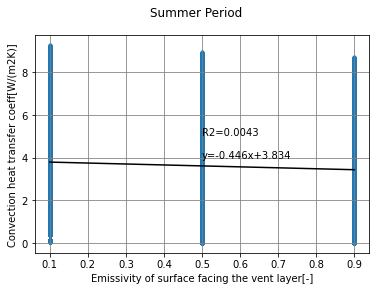

In [20]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_cv"
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Convection heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_cv"
      )

## 対流熱伝達率の推定
### 冬期と夏期の差がほとんどないので、データを統合する

In [21]:
df_target = pd.concat([df_winter, df_summer])
df_target

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.538192,0.817940,-2.315751,2.842171e-14,2.886580e-15,-1.776357e-15,-2.842171e-14,-2.220446e-16,-24.538192,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.941901,0.831397,-2.401513,0.000000e+00,7.105427e-15,-7.105427e-15,5.684342e-14,-8.881784e-16,-24.941901,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.989114,0.832970,-2.426156,2.842171e-14,0.000000e+00,-3.552714e-15,2.842171e-14,4.440892e-16,-24.989114,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.898810,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.907471,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.476449,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.754820,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.700991,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,49.057263,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


### 最小二乗法による回帰モデルを作成

In [22]:
formula_2 = "h_cv ~ v_a"
model_1 = ols(formula_2, df_target).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_cv   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 1.760e+06
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -4.4017e+05
No. Observations:              334611   AIC:                         8.803e+05
Df Residuals:                  334609   BIC:                         8.804e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2521      0.002    508.015      0.000       1.247       1.257
v_a            5.0653      0.004   1326.598      0.000       5.058       5.073
==============================================================================
Omnibus:                    11490.103   Durbin-Watson:                   0.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12708.082
Skew:                           0.476   Prob(JB):                         0.00
Kurtosis:                       2.940   Cond. No.                         3.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 推定値の精度を確認

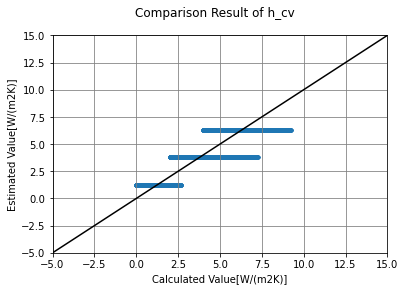

In [23]:
setPltComparison(df = df_target,
       fig_title = "Estimation Result of Convection heat transfer coeff",
       x_label = "Calculated Value[W/(m2K)]",
       y_label = "Estimated Value[W/(m2K)]", 
       x_data_name = "h_cv",
       y_data = model_1.predict()
      )

## 対流熱伝達率の感度解析

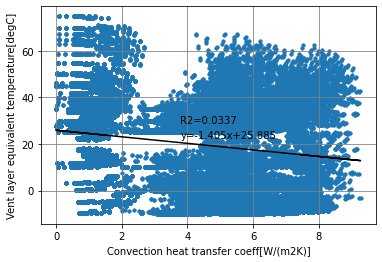

In [24]:
setPltSingle(df = df_target,
       fig_title = "",
       x_label = "Convection heat transfer coeff[W/(m2K)]",
       y_label = "Vent layer equivalent temperature[degC]", 
       x_data_name = "h_cv",
       y_data_name = "theta_as_e"
      )

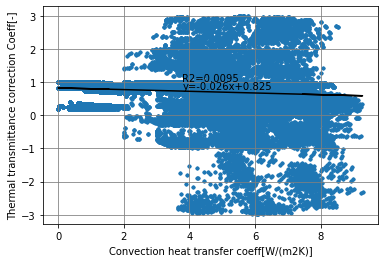

In [25]:
setPltSingle(df = df_target,
       fig_title = "",
       x_label = "Convection heat transfer coeff[W/(m2K)]",
       y_label = "Thermal transmittance correction Coeff[-]", 
       x_data_name = "h_cv",
       y_data_name = "k_e"
      )